# Solving Single Decisions

## The "Party Problem" example

JMA 11 Jan 2024

In [82]:
# Imports from the python standard library
import math, re, os, sys
from pathlib import Path
import itertools            # to flatten lists

# Import array and dataframe packages
import numpy as np
# import numpy.linalg as la
import pandas as pd

import networkx as nx

# for extract_net
# from ID_operations import * 
from potential_operations import *
import BN

# Import the bokeh python wrappers for javascript plots
#  - a preferred visualization tool
# from bokeh.plotting import figure, show
# from bokeh.models import ColumnDataSource, VBar, Span
# from bokeh.io import output_notebook
# output_notebook()

NETWORK_FILE = 'PartyProblem_asym.xdsl' # 'PartyProblem_asym.xdsl'  # 

In [83]:
# BN structure is contained under the node branch
parsed = BN.extract_net(NETWORK_FILE)
nodes, extensions = parsed
# tags tell the node type. 
[( k.get('id'), k.tag) for k in nodes]

found nodes


[('Party_location', 'decision'),
 ('Weather', 'cpt'),
 ('Preferences', 'utility'),
 ('Utility', 'maux'),
 ('Adjustor', 'cpt'),
 ('Detector', 'cpt')]

## Bayes networks object

### Include state and variable names to tensor dimensions

### Add graph structure

It contains 

- the parse of the network as a dictionary with node names as keys
- The graph object showing network structure
- Node Potential objects for computation. 


In [84]:
# CPT contents are stored in row major order (first row, second row, ...)
# Parents are the first matrix dimension -- matrix is Row Markov
pp_net = BN.reap(parsed)
pp_net.pr_nodes()


Edges:  [('Weather', 'Preferences'), ('Party_location', 'Preferences'), ('Weather', 'Detector'), ('Adjustor', 'Detector')] 

>>> Party_location <<<
Party_location: decision
	states: ['Outdoors', 'Porch', 'Indoors']
	parents: []
	named tensor: [('Party_location', 'm')], [3]
       [0.3333, 0.3333, 0.3333]

>>> Preferences <<<
Preferences: utility
	states: ['utility']
	parents: ['Weather', 'Party_location']
	named tensor: [('Weather', 'c'), ('Party_location', 'c'), ('Preferences', 'm')], [2, 3, 1]
       [[[100.],
         [ 90.],
         [ 40.]],

        [[  0.],
         [ 20.],
         [ 50.]]]

>>> Weather <<<
Weather: cpt
	states: ['Sunshine', 'Rain']
	parents: []
	named tensor: [('Weather', 'm')], [2]
       [0.4000, 0.6000]

>>> Adjustor <<<
Adjustor: cpt
	states: ['absent', 'present']
	parents: []
	named tensor: [('Adjustor', 'm')], [2]
       [0.1000, 0.9000]

>>> Detector <<<
Detector: cpt
	states: ['SaySun', 'SayRain']
	parents: ['Weather', 'Adjustor']
	named tensor: [('Wea

reap: Party_location, decision
reap: Weather, cpt
reap: Preferences, utility
reap: Utility, maux
Unsupported node type: maux
reap: Adjustor, cpt
reap: Detector, cpt


In [85]:
pp_net.pr_influences()



Node	{ancestors}
	{descendants}

Weather :  set() 
	 {'Preferences', 'Detector'} 

Preferences :  {'Weather', 'Party_location'} 
	 set() 

Party_location :  set() 
	 {'Preferences'} 

Detector :  {'Weather', 'Adjustor'} 
	 set() 

Adjustor :  set() 
	 {'Detector'} 



### Extract matrices as tensors.  _List all tensors_

In [86]:
pp_net.pr_named_tensors()

Party_location 
	 OrderedDict({'Party_location': 'm'})
	tensor([0.3333, 0.3333, 0.3333]) 

Preferences 
	 OrderedDict({'Weather': 'c', 'Party_location': 'c', 'Preferences': 'm'})
	tensor([[[100.],
         [ 90.],
         [ 40.]],

        [[  0.],
         [ 20.],
         [ 50.]]]) 

Weather 
	 OrderedDict({'Weather': 'm'})
	tensor([0.4000, 0.6000]) 

Adjustor 
	 OrderedDict({'Adjustor': 'm'})
	tensor([0.1000, 0.9000]) 

Detector 
	 OrderedDict({'Weather': 'c', 'Adjustor': 'c', 'Detector': 'm'})
	tensor([[[0.5100, 0.4900],
         [0.8700, 0.1300]],

        [[0.4800, 0.5200],
         [0.4000, 0.6000]]]) 



In [87]:
## pretty print one of the variables
pp_net.pr_one_dim_table( 'Weather', tablefmt= '.4f', headers= ['State', 'Value'])



 *** Weather ***
State       Value
--------  -------
Sunshine      0.4
Rain          0.6


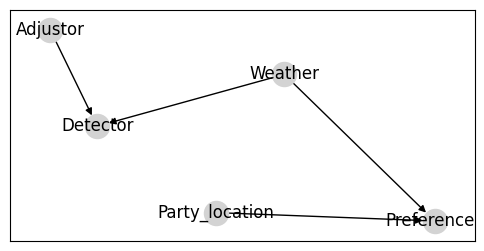

In [88]:
# BN Graph
pp_net.pr_network()

### Utilities

Convert "dollar" utilities to utility with risk tolerance == 0.5

In [89]:
# Utility matrix, as a Potential
outcome_potential = pp_net.get_potential('Preferences')
outcome_potential.pr_potential()

	named tensor: [('Weather', 'c'), ('Party_location', 'c'), ('Preferences', 'm')], [2, 3, 1]
       [[[100.],
         [ 90.],
         [ 40.]],

        [[  0.],
         [ 20.],
         [ 50.]]]


In [90]:
utility_p = named_tensor_apply(outcome_potential, delta_utility, exponand = 0.5, normalize = 50)
utility_p.pr_potential()

	named tensor: [('Weather', 'c'), ('Party_location', 'c'), ('Preferences', 'm')], [2, 3, 1]
       [[[1.0000],
         [0.9504],
         [0.5675]],

        [[0.0000],
         [0.3229],
         [0.6667]]]


In [91]:
# Check that the inverse function returns the outcome values
named_tensor_apply(utility_p, delta_inverse_utility, exponand = 0.5, normalize = 50)

OrderedDict({'Weather': 'c', 'Party_location': 'c', 'Preferences': 'm'})
	tensor([[[100.],
         [ 90.],
         [ 40.]],

        [[ -0.],
         [ 20.],
         [ 50.]]])

## Solving the party problem

_Using just potential operations (not Node removal_)

To determine the optimal policy --

* join Adjustor and Detector CPTs, marginalize out Adjustor
* join Detector and Weather CPTs, marginalize out Detector 
* join Weather with Utility (Decision has unit values for all options)
* marginalize out unobserved Weather 
* Maximize over options
* (marginalize out Utility to get decision lottery)

### First solution - only prior probabilities, no observation 

__The Adjustor can be absorbed into the Detector__

In [92]:
# Remove Adjustor
detector_p = pp_net.get_potential('Detector')
adjustor_p = pp_net.get_potential('Adjustor')
detector_marginal = absorb_parent(adjustor_p, detector_p)
print('P(Detector | Weather): ')
detector_marginal.pr_potential()

P(Detector | Weather): 
	named tensor: [('Weather', 'c'), ('Detector', 'm')], [2, 2]
       [[0.8340, 0.1660],
        [0.4080, 0.5920]]


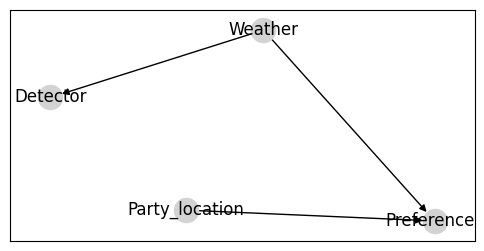

In [93]:
# Now that the potential is removed, 
# remove Adjustor from the network and redraw the graph
pp_net.remove_node('Adjustor', show_graph=True)

__The Detector is a barren node; remove it.__

This has the same effect as reversing the arc and expecting out "Detector."

Note: This just returns the Weather prior, as it should.

In [94]:
# # Reverse Detector and Weather. TODO Or just remove  the barren detector node?  
# #  
# weather_p = pp_net.get_potential('Weather')
# # TODO Removal of a child into a parent (implicit arc reversal)
# wd_joint = absorb_parent(weather_p, detector_marginal)  
# # remove the Detector dimension
# detector_preposterior = marginalize_out(wd_joint, 'Weather')
# weather_posterior = condition_probability(wd_joint, 'Detector')
# detector_preposterior.pr_potential()

In [95]:
# Weather distribution
pp_net.get_potential('Weather')  

OrderedDict({'Weather': 'm'})
	tensor([0.4000, 0.6000])

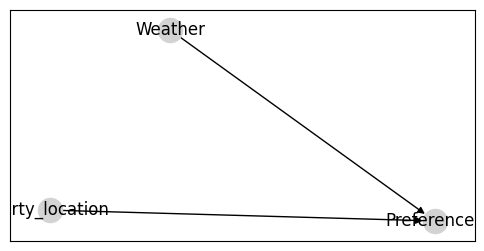

In [96]:
# Delete the Detector node from the network.  No change to Weather potential is needed
pp_net.remove_node('Detector', show_graph=True)

### Compute the expected outcome value

The expected value __before__ applying the utility function

Note that the optimal choice is implicit in the EV potential. The party location table is not used here. 

In [97]:
location_choice = pp_net.get_potential("Party_location")
location_choice

OrderedDict({'Party_location': 'm'})
	tensor([0.3333, 0.3333, 0.3333])

In [98]:
outcome_potential.pr_potential()

	named tensor: [('Weather', 'c'), ('Party_location', 'c'), ('Preferences', 'm')], [2, 3, 1]
       [[[100.],
         [ 90.],
         [ 40.]],

        [[  0.],
         [ 20.],
         [ 50.]]]


__Find best policy before knowing the weather outcome__

First take expectation over the weather outcomes, then choose the best option.
These are the values, depending on location:

In [99]:

weather_marginal = pp_net.get_potential('Weather')
alternatives = pp_net.get_node('Party_location').get_states()
expected_outcome = marginalize_utility(outcome_potential, weather_marginal)
# The expected value of each alternative
print('Alternatives:', alternatives)
expected_outcome.pr_potential()

Alternatives: ['Outdoors', 'Porch', 'Indoors']
	named tensor: [('Party_location', 'c')], [3]
       [40., 48., 46.]


__Choose the best location using expected values.__

In [112]:
max_value, which_choice = maximize_utility(expected_outcome, pp_net.get_potential("Party_location"))
str(np.array(alternatives)[which_choice.policy == 1]), max_value.cpt.item()

("['Porch']", 48.0)

In [101]:
# Compute optimal policy from expected outcome.
# maximize over this dimension
# Replace decision policy with 0-1 values indicating optimal policy. 

__Compute expected risk-adjusted utility__

In [102]:
# We must drop the singleton dim first from the utility?
utility_p.pr_potential()

	named tensor: [('Weather', 'c'), ('Party_location', 'c'), ('Preferences', 'm')], [2, 3, 1]
       [[[1.0000],
         [0.9504],
         [0.5675]],

        [[0.0000],
         [0.3229],
         [0.6667]]]


In [103]:
# Utility expected value over decision alternatives
expected_utility = marginalize_utility(utility_p, weather_marginal)
print('Alternatives:',pp_net.get_node('Party_location').get_states())
expected_utility.pr_potential()

Alternatives: ['Outdoors', 'Porch', 'Indoors']
	named tensor: [('Party_location', 'c')], [3]
       [0.4000, 0.5739, 0.6270]


In [104]:
v, which_choice = maximize_utility(expected_utility, pp_net.get_potential("Party_location"))
str(np.array(alternatives)[which_choice.policy == 1]),\
f'{v.cpt.item():.3f} = $ {delta_inverse_utility(v.cpt.item(), exponand = 0.5, normalize = 50):.2f}'

("['Indoors']", '0.627 = $ 45.83')

### Party problem 2; when Weather is observed before having to make the choice

To solve this --

* Add an informational "cause" to the decision node by
* Using the Weather marginal as a conditioning for Party location

_alternately add the conditioning arc in the xdsl file instead of programmatically modifying it._

In [105]:
conditioned_choice = condition_decision(location_choice, weather_marginal)
conditioned_choice.pr_potential()

	named tensor: [('Weather', 'c'), ('Party_location', 'm')], [2, 3]
       [[0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333]]


In [116]:
max_cond_value, which_choice = maximize_utility(outcome_potential, conditioned_choice)
# str(np.array(alternatives)[which_choice.policy == 1]), max_value.cpt.item()
print('Best choice depending on knowing the weather:')
# which_choice.policy
BN.pr_table(max_cond_value, 'Weather', pp_net.get_node('Weather').get_states())
print(f'\nHence the value of knowing the weather is {max_cond_value.cpt[0].item()} - {max_value.cpt.item()}'
f' = {max_cond_value.cpt[0].item() - max_value.cpt.item()}')

Best choice depending on knowing the weather:
 *** Weather ***
--------  ---
Sunshine  100
Rain       50
--------  ---

Hence the value of knowing the weather is 100.0 - 48.0 = 52.0


_Repeat the analysis for risk averse choice_ 


In [107]:
# TODO what is the last dim?  Need to remove it. 
fig, ax = plt.subplots(1,2, figsize = (6, 2.6))
policy_values_2d_a = pd.DataFrame(policy_values.squeeze(0)[:,:,1], columns = pp_net.n_dict['Detector']['states'], 
                                index = pp_net.n_dict['Party_location']['states'])
sn.heatmap(policy_values_2d_a, annot=True, xticklabels=True, yticklabels=True, ax=ax[0])
policy_values_2d_b = pd.DataFrame(policy_values.squeeze(0)[:,:,0], columns = pp_net.n_dict['Detector']['states'], 
                                index = pp_net.n_dict['Party_location']['states'])
sn.heatmap(policy_values_2d_b, annot=True, xticklabels=True, yticklabels=True, ax=ax[1])

NameError: name 'plt' is not defined

In [ ]:
# Value with information. 
# However utility should be applied after computing expected values to get certain equivalents
# sigh
# 0.7782 * 0.44 + 0.6557 * 0.56
decn.values @ get_potential('Weather', pp_net.n_dict).p